# Notebook for analyzing array data from a specific project label blinded

In [37]:
%load_ext autoreload
%autoreload
%matplotlib inline

from __future__ import division, print_function
import sys as sys
sys.path.append('../Utils')
import os as os
import numpy as np
import scipy.stats
import hclusterplot as hcp
import myboxplot as mbp
import scipy.cluster.hierarchy as sch
import statsmodels.api as sm
from IPython.display import display, HTML
import amplotlib as amp
import amutils as amutils
import matplotlib as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Project specific parameters that must be set:

In [19]:
pathogen_name = 'Influenza'
project_name = 'FIM12';

# Names of HA and NA proteins that are on the array. 
prot_names = ['Cal_HA', 'Vic_HA', 'Cal_NA', 'Vic_NA', 'Wis_HA', 'Wis_NA']
prot_strs = ['H1', 'N1', 'H3', 'N2', 'B_HA', 'B_NA']

# Labels of the experimental groups (not including BSA, or any other background):
#exp_groups = ['Normal', 'Obese']
#exp_group_prefixes = ['Obese_', 'Normal_']
exp_groups = ['Blinded'] # here we assumed that labels are not provided, so exp groups are all set to a single label currently ('Blinded')
exp_group_prefixes = ['Blinded', 'BSA']

# Summary statistics (breadth and magnitude) that we would like to visualize. 
# if set to empty, will plot all.
#arr_summary_stats = ['H7_mag', 'N9_mag', 'H1_mag', 'N1_mag']
arr_summary_stats = ['H1_mag', 'N1_mag', 'H3_mag', 'N2_mag', 'B_HA_mag', 'B_NA_mag']
# Paths:
ROOT_PATH = '/Users/thertz/Dropbox/HertzLab/'
load_path = '/Users/thertz/temp/monto fim12/'
#load_path = os.path.join(ROOT_PATH, 'ArrayData', pathogen_name, project_name)
fig_path = load_path + '/TestFigs/'


## Additional parameters that have usual defaults:

In [20]:
type_flag  = 'median' # uses the median over replicates of an antigen. Can also be 'mean'
color_flags = ['635']
color_tags = ['IgG']
font_size = 12

y_lims = [0, 65000] # max height of y in graphs
y_lims_summary = [0, 32500] # max height of y in summary stat graphs

# Threshold by which to flag antigens as ones that have high background and should be removed from analysis 
# (typically using a BSA negative control).
bg_threshold = 2000 

# summary stat used for group comparisons and for plotting gropu responses - and cluster responses
summary_method = 'median' 

## Read in data from matlab mat files
This is obsolete and will be modified in future version.

In [21]:
experiment_dates = ['12_02_2015']
arr_df, antigens = amutils.load_array_data(load_path, project_name, experiment_dates)

/Users/thertz/temp/monto fim12/12_02_2015/FIM12_12_02_15_arrayData_median.mat


## Background subtraction
BSA responses are used for background subtraction and the maximal BSA response is subtracted from all antigens.

In [22]:
arr_df, bg_df = amutils.backgound_subtract_array_data(arr_df, antigens, bg_name='BSA')

## Index and group dictionary setup:
Here specific dictionaries for accessing subsets of the array limited to given protein are defined. They are based on the prot_names, prot_strs and exp_groups defined above.

In [23]:
ind_dict, time_dict, group_inds, group_labels = \
    amutils.initialize_indexing_dictionaries(arr_df, prot_names, prot_strs, exp_groups)

# add numeric label column to arr_df for stat testing.
arr_df = amutils.add_numeric_labels_to_arr_df(arr_df, group_labels)

## Breadth and Magnitude summary statistics of the array data:

In [24]:
arr_df = amutils.compute_breadth_and_magnitude_summary_stats(arr_df, prot_names, prot_strs, ind_dict)

,Cal_HA_1,Cal_HA_2,Cal_HA_3,Cal_HA_4,Cal_HA_5,Cal_HA_6,Cal_HA_7,Cal_HA_8,Cal_HA_9,Cal_HA_10,...,Wis_NA_83_binarized,Wis_NA_84_binarized,Wis_NA_85_binarized,Wis_NA_86_binarized,Wis_NA_87_binarized,Wis_NA_88_binarized,Wis_NA_89_binarized,Wis_NA_90_binarized,Wis_NA_91_binarized,B_NA_breadth
80392_1,11851,937,59932,1077,5611,1973,842,1961,18576,12298,...,1,1,0,0,1,1,1,1,0,71
80392_3,6391,481,39207,64,3462,1386,1221,1983,12226,4880,...,0,1,0,0,1,1,0,1,0,54
80385_2,17770,1040,25895,1607,18790,1276,414,3175,9500,20893,...,1,1,0,0,1,1,1,1,0,72
80403_1,28136,2814,45225,6578,32369,3521,6562,8903,28003,40183,...,1,1,1,0,1,1,1,1,0,79
80403_3,25050,2502,30469,5120,28962,1213,4161,10774,21573,28265,...,1,1,1,0,1,1,1,1,0,79
80392_2,14120,924,49851,718,4820,2018,3239,5367,15529,7113,...,0,1,0,0,1,1,1,1,0,65
80385_1,12291,877,18474,626,13130,1025,425,2426,14764,15614,...,0,1,0,0,1,1,1,1,0,66
80385_3,17529,1228,26547,1042,17395,1571,406,3273,12411,17957,...,0,1,1,0,1,1,1,1,0,75
80403_2,30603,3333,22095,4175,30749,1733,5008,6991,24648,25656,...,1,1,1,0,1,1,1,1,0,79


## Clustering analysis:

In [25]:
#-------------------------------------------------------------------------------#
# 1. Clustering analysis:
#-------------------------------------------------------------------------------#
# Cluster using Andrew's package 
# (complete linkage using Spearman correlation coefficient):

# Unsupervised clustering parameters:
num_clusters = 3 # number of clusters in the data (or expected number)

# minimal threshold for responces to be included in clusterSamplesByResponseVectors, point below data is noise
minResponseThreshold = 2000 

dist_mat, Z_struct, dend, clusters = \
    amutils.cluster_array_data_by_proteins(arr_df=arr_df, sample_inds=time_dict['all'],
                                           num_clusters=num_clusters, ind_dict=ind_dict)

## Compute Median responses for each protein (here all samples belong to the same group)

In [26]:
group_medians, group_stds = \
    amutils.compute_exp_group_summary_stats_by_protein(arr_df, prot_names, prot_strs, group_inds, ind_dict)

['Blinded']

## Data Visualzation:

## Responses by protein:

### 1. Median responses by all samples

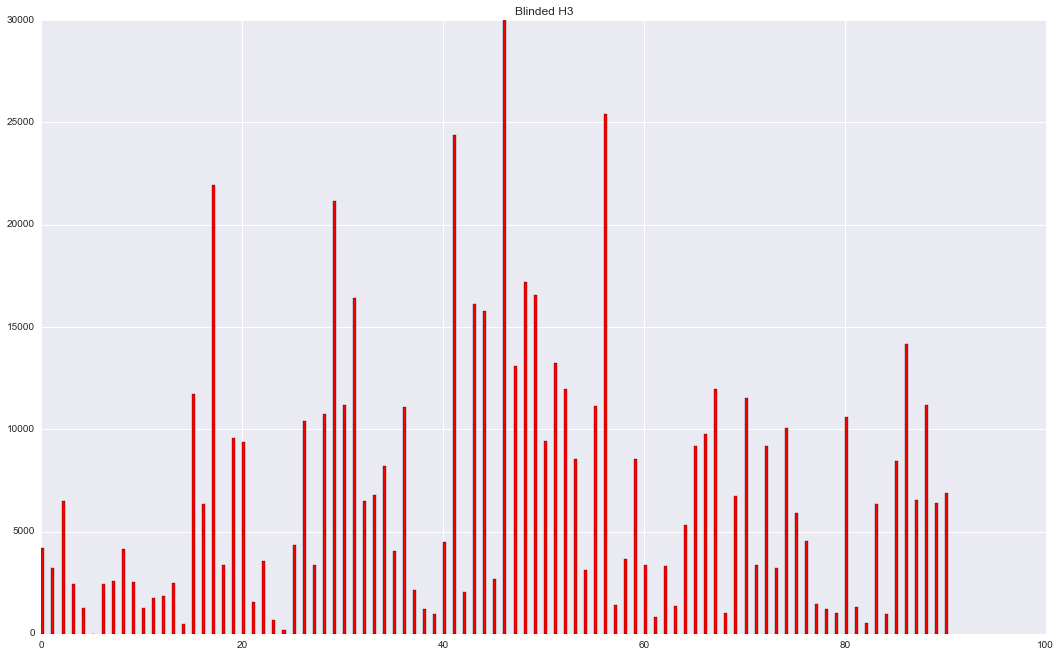

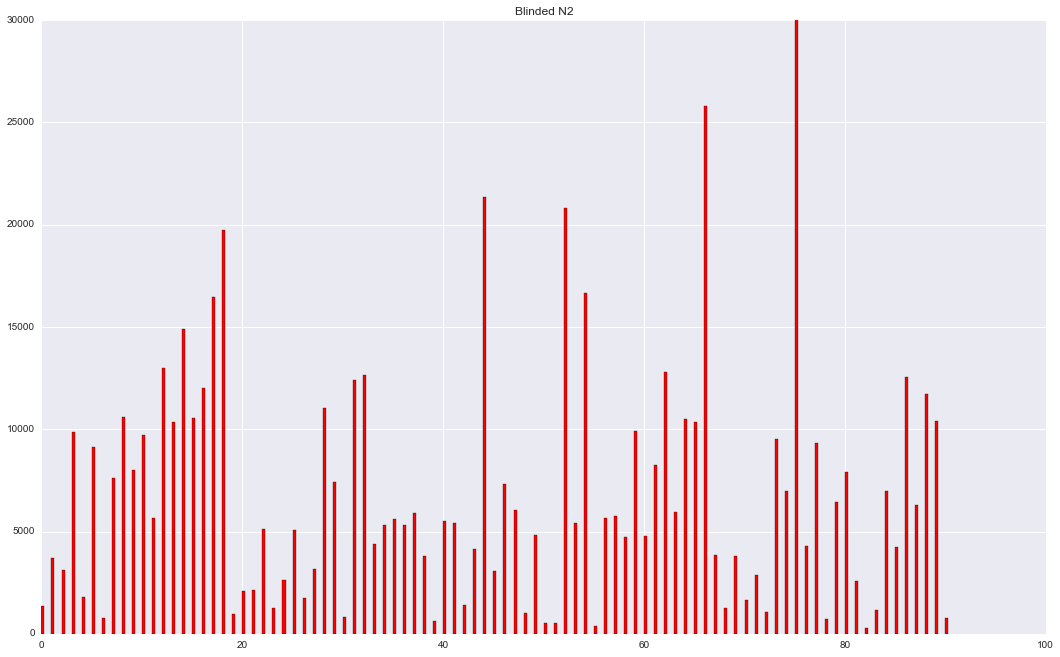

In [27]:
# Plot figures of median responses by treatment group - Note here names are from prot_strs and NOT prot_names
for p in ['H3',  'N2']:
    amp.plot_median_responses_by_exp_groups(group_medians, exp_groups, prot_str=p,
                                            fig_path=None, fig_prefix=None, fig_size=(18,11), y_lims=[0, 30000])
    #display(HTML("<HR>"))

### 2. Raw responses by protein:

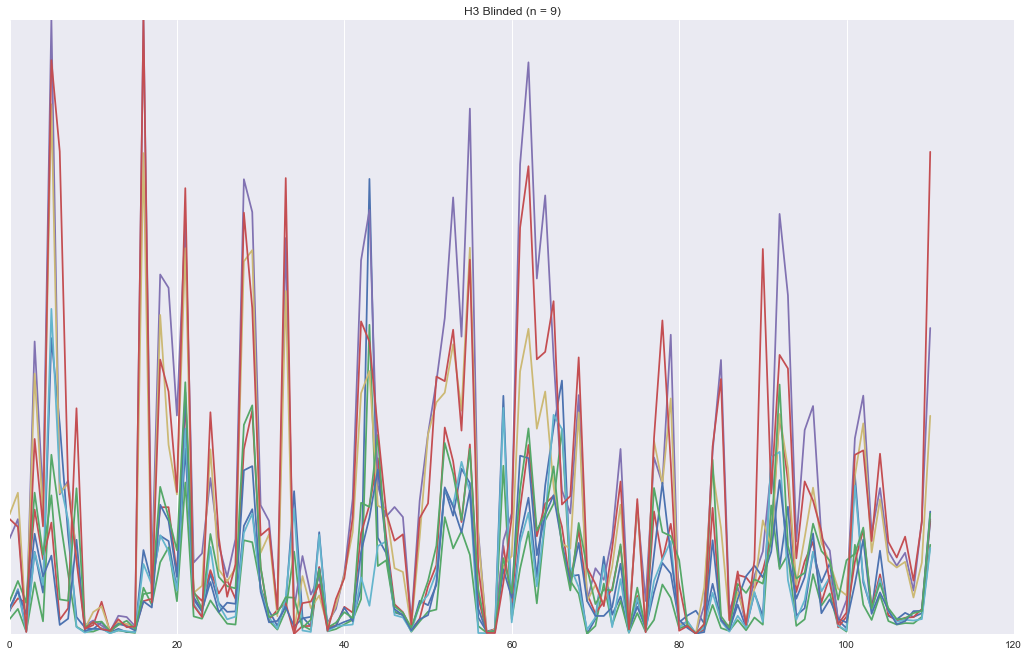

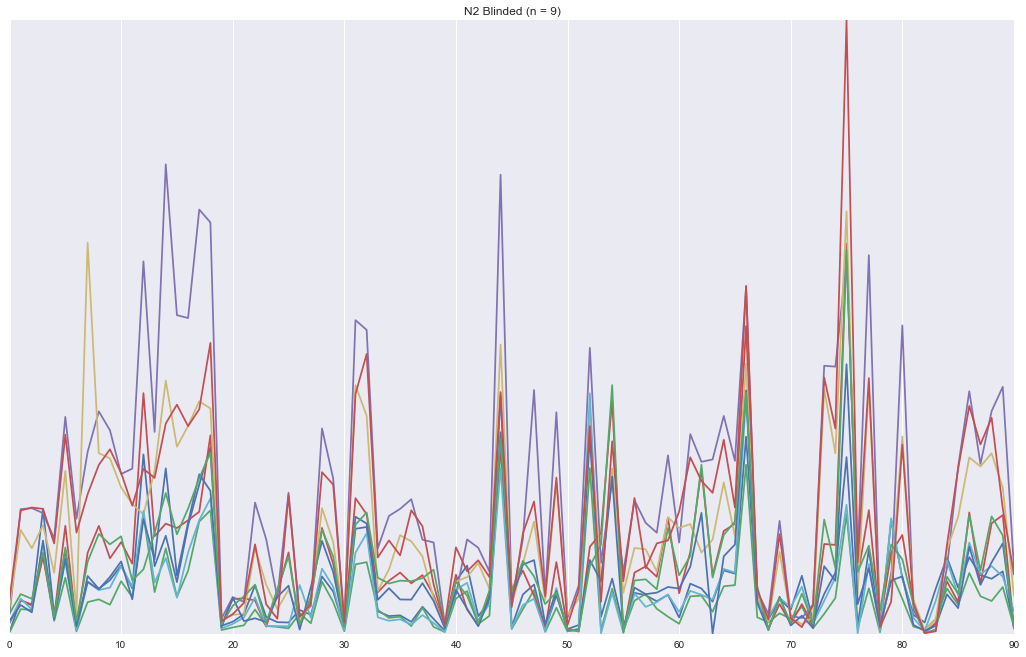

In [42]:
# Plot responses by groups for each protein separately - groups can be prot_strs, or any subset of these:
# the second list is prot_strs for figure titles. 
# you can use this for all proteins:
# for p, s in zip(prot_names, prot_strs):
for p, s in zip(['Vic_HA', 'Vic_NA'], ['H3', 'N2']):
    amp.plot_responses_by_exp_groups(arr_df=arr_df, antigen_inds = ind_dict[p],
                                     exp_groups=exp_groups, fig_path=None, fig_prefix=s, y_lims=y_lims)
    #plt.show()
    #display(HTML("<HR>"))
    

## Plot responses of single ptids:

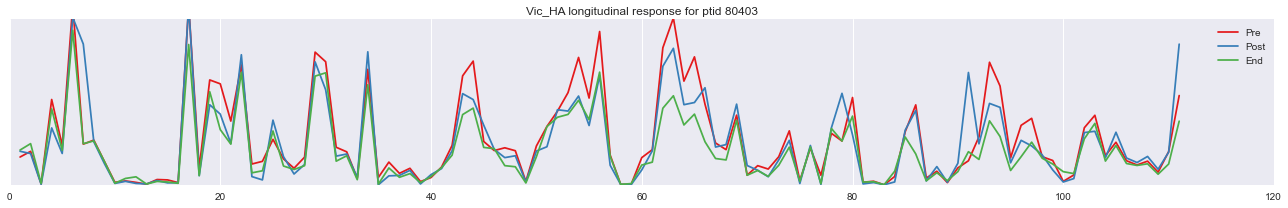

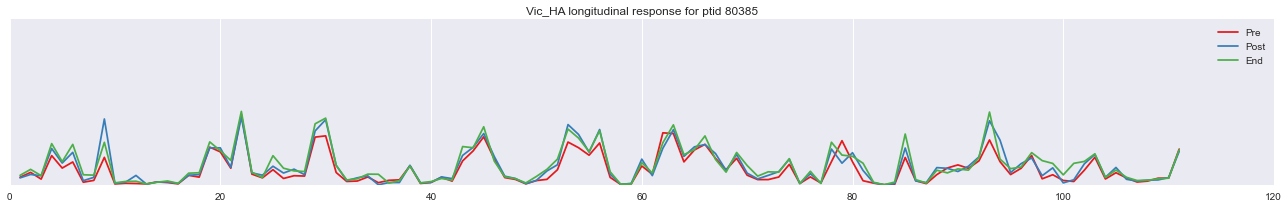

In [69]:
reload(amp)
timepoint_label_dict = {'1': 'Pre', '2': 'Post', '3':'End'}
for p in ['Vic_HA']:
    for ptid in ['80403', '80385']:
        curr_df = arr_df[arr_df.index.str.startswith(ptid)]
        curr_df = curr_df.sort()
        timepoints = curr_df.index.str[-1].tolist()
        timepoint_labels = []
        for t in timepoints:
            timepoint_labels.append(timepoint_label_dict[t])
        amp.plot_longitudinal_responses_by_ptid(resp_mat=curr_df[ind_dict[p]], prot_name=p, ptid=ptid, timepoint_labels=timepoint_labels, plot_type='line', fig_size=(18,3))

## Clustering plots

### 1. Dendrograms:

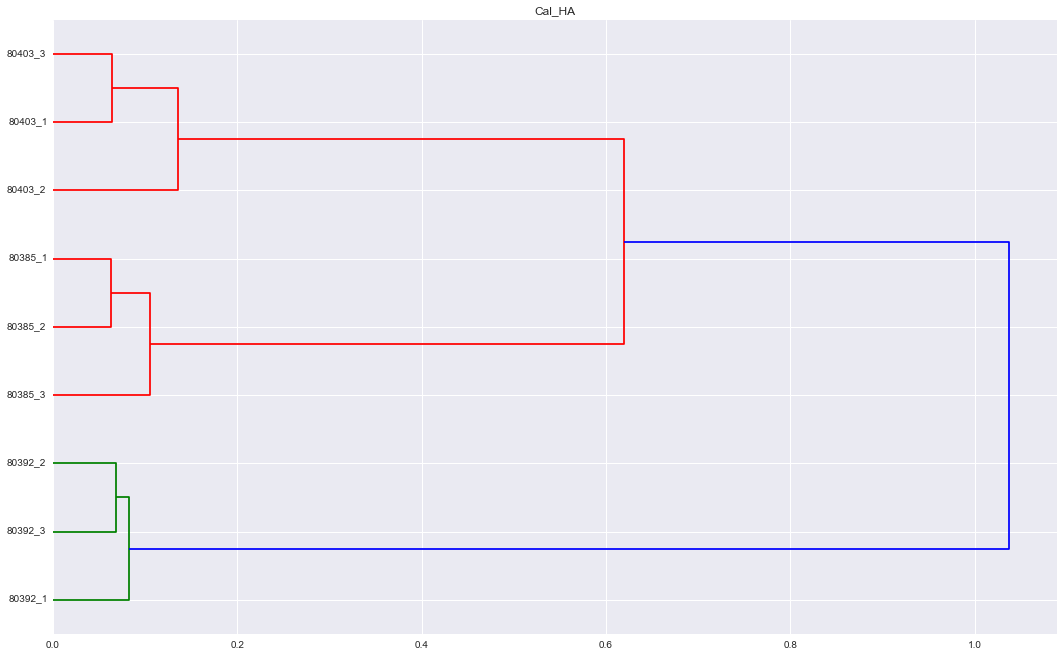

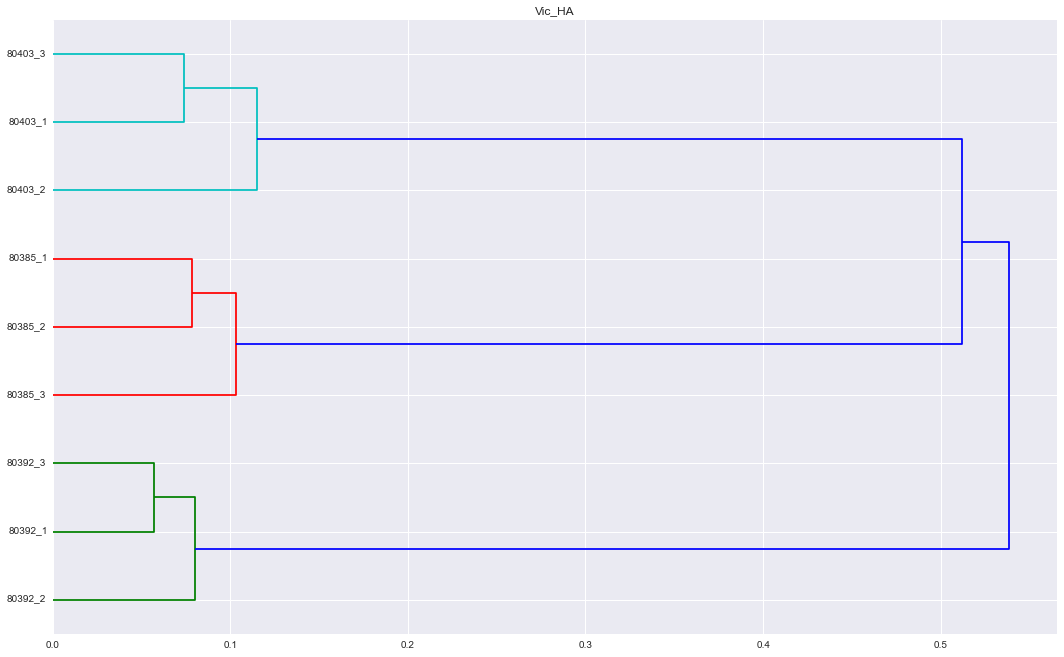

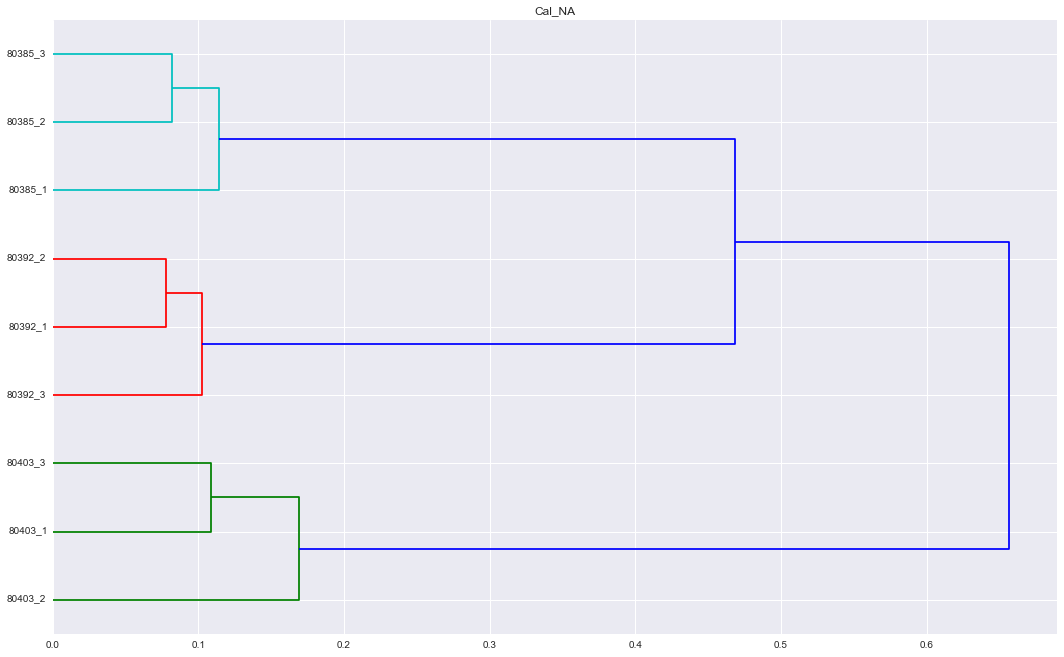

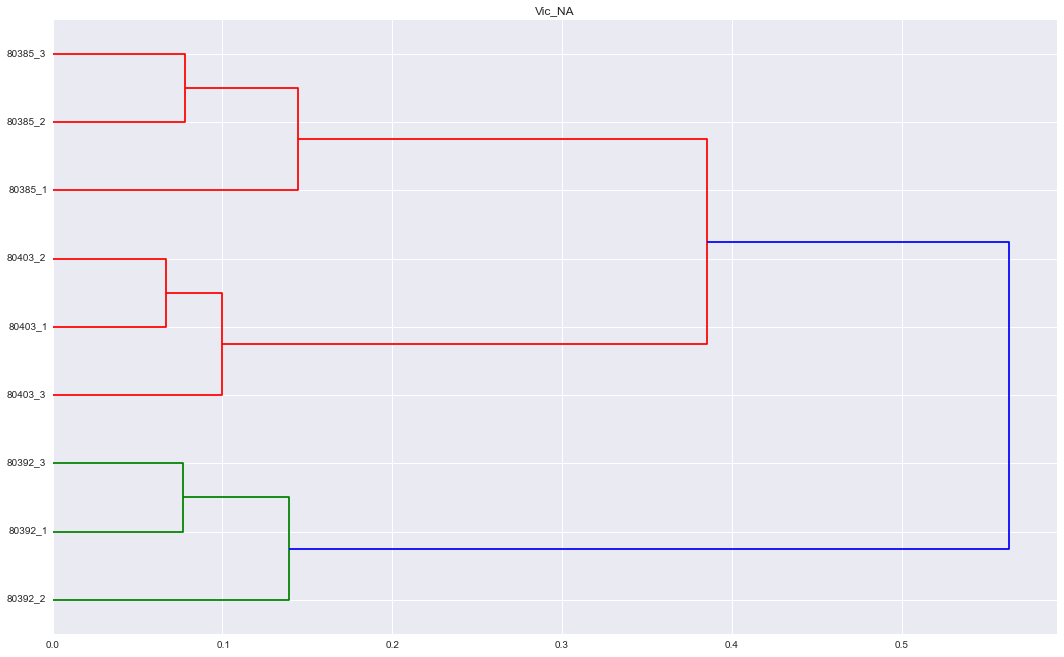

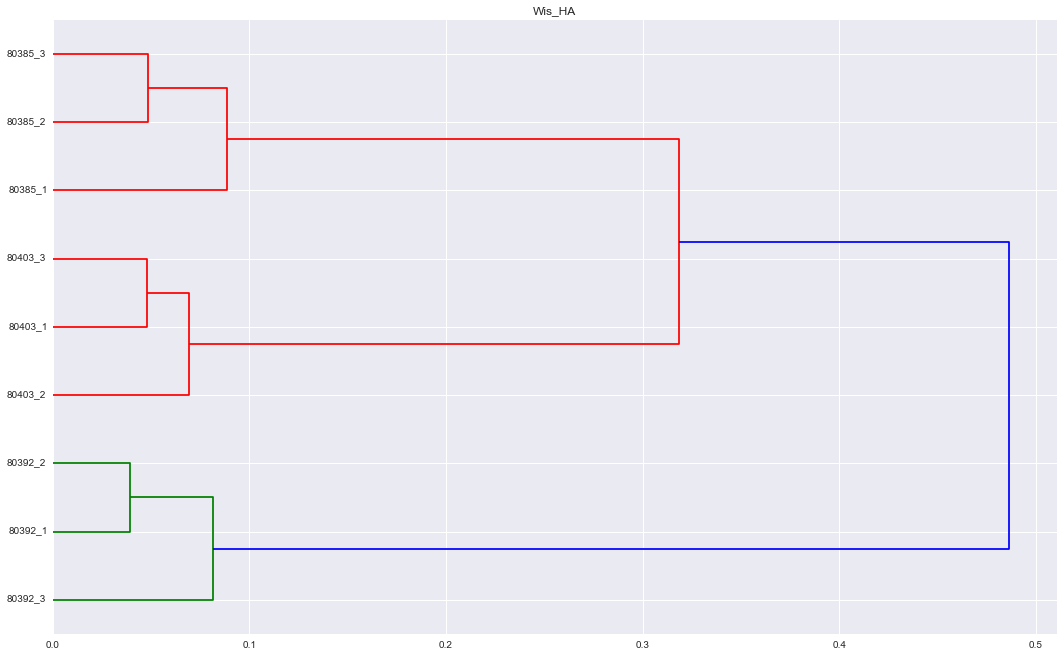

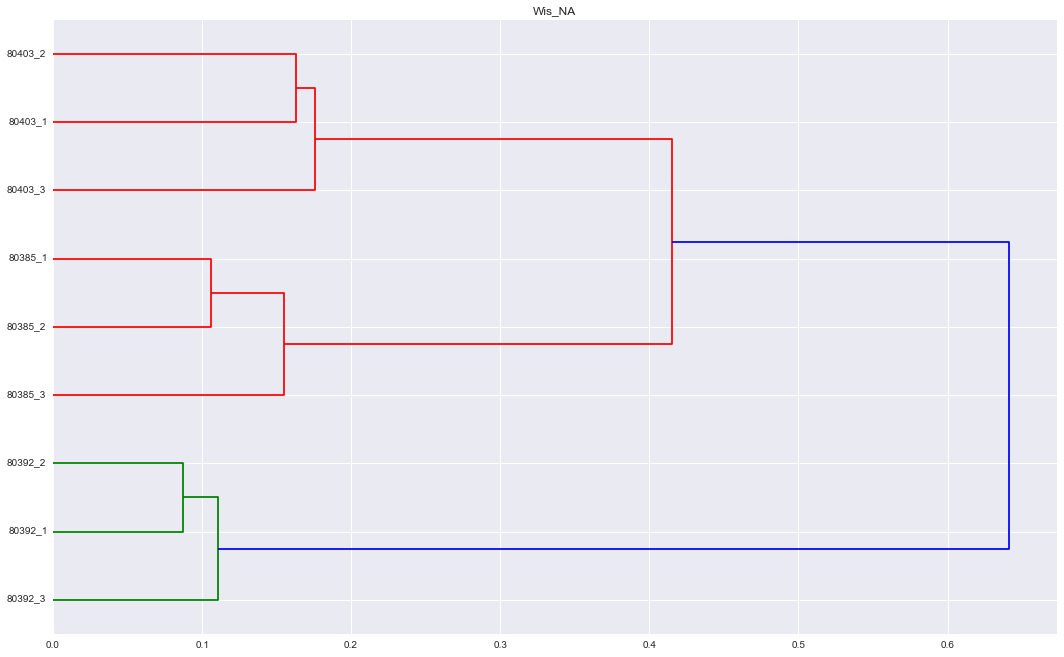

In [15]:
amp.plot_clustering_dendrograms(Z_struct=Z_struct, prot_names=prot_names, labels=arr_df.index, fig_path=None)

### 2. Raw responses by cluster:

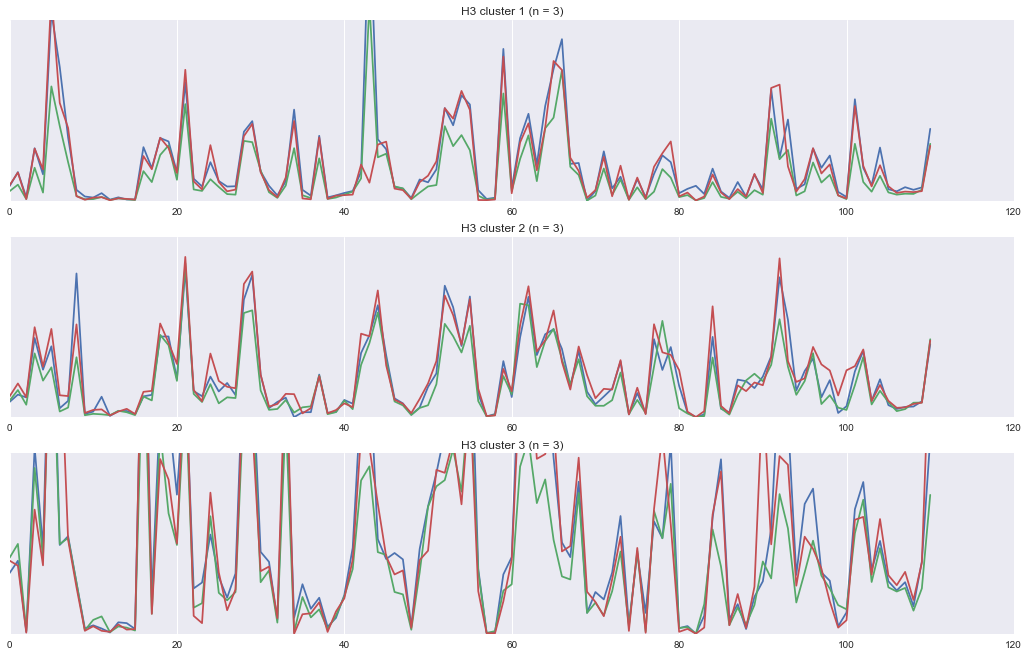

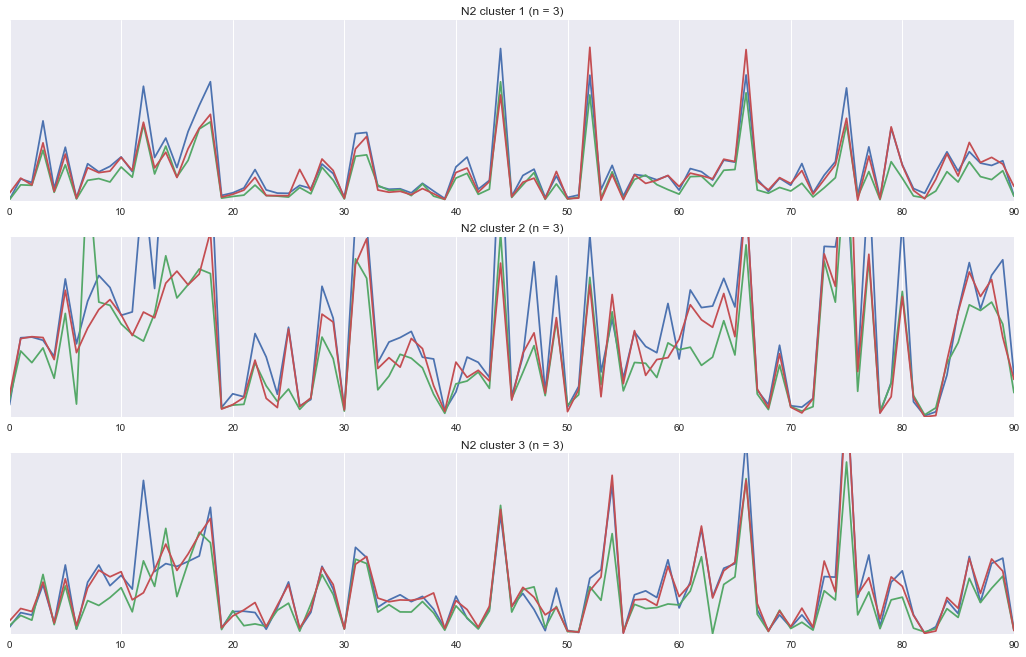

In [41]:
# plot raw responses by cluster:
for p, s in zip(['Vic_HA', 'Vic_NA'], ['H3', 'N2']):
    amp.plot_raw_responses_by_clusters(arr_df, ind_dict[p], num_clusters, clusters=clusters[p],
                                          fig_path=None, fig_prefix=s, fig_size=(18,11), y_lims=[0, 30000])
    
    #plt.show()
    #display(HTML("<HR>"))

### 3. Median responses by cluster:

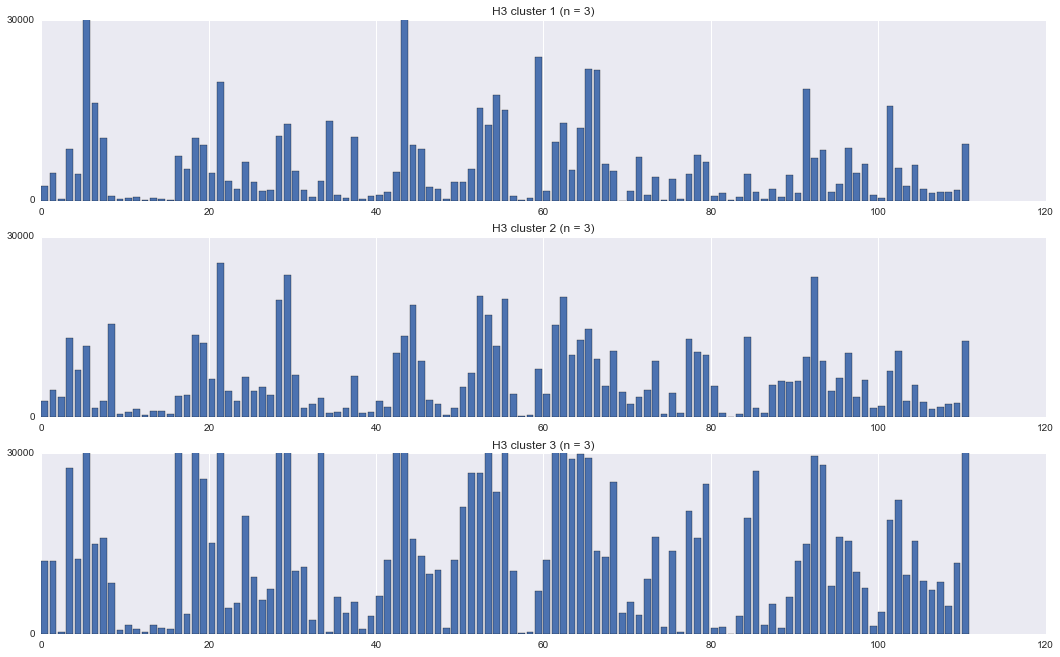

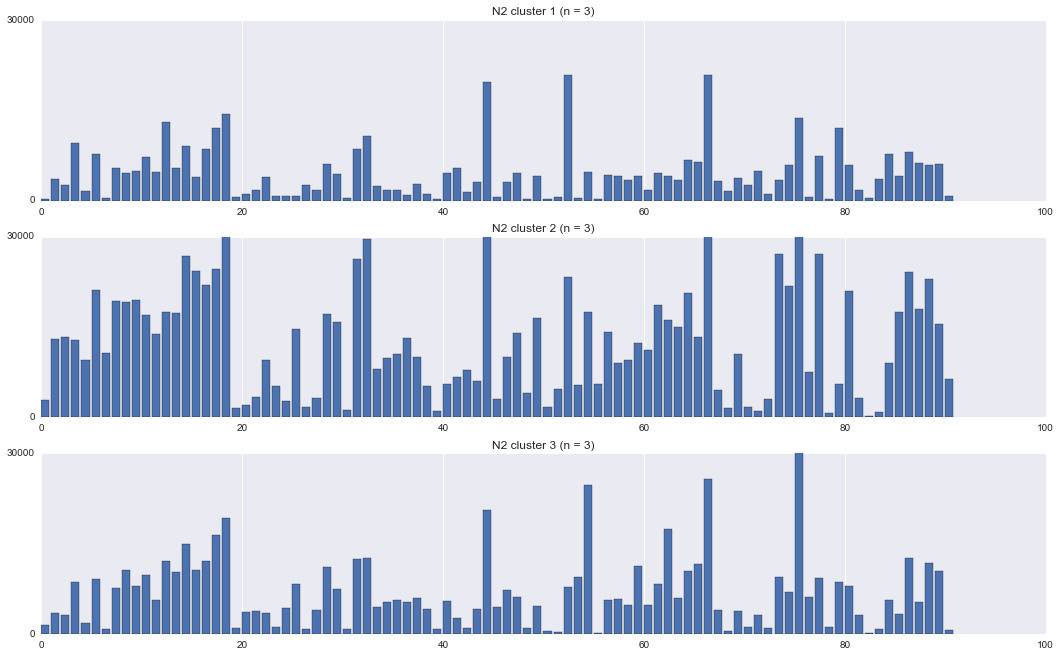

In [40]:
# plot median responses by cluster:
for p, s in zip(['Vic_HA', 'Vic_NA'], ['H3', 'N2']):
    amp.plot_median_responses_by_clusters(arr_df, ind_dict[p], num_clusters, clusters=clusters[p],
                                          fig_path=None, fig_prefix=s, fig_size=(18,11), y_lims=[0, 30000])
    #display(HTML("<HR>"))